# Goal: Describe CCG opiate prescribing in England using the GP prescribing data.

In [1]:
import os, datetime
import pandas as pd
import pickle
import folium
from pandas import Series, DataFrame, Panel
from datetime import datetime, date, time

In [2]:
# Data sources:
# wget all the presentation prescribing datas here http://www.hscic.gov.uk/gpprescribingdata
# get gp pop sizes and gp-ccg mapping here https://indicators.ic.nhs.uk/download/Clinical%20Commissioning%20Group%20Indicators/Data/GP_registered_patients_2012.csv
# get ccg pop sizes here https://indicators.ic.nhs.uk/download/Clinical%20Commissioning%20Group%20Indicators/Data/CCG_registered_patients_2012.csv
# get map boundary here https://geoportal.statistics.gov.uk/Docs/Boundaries/Clinical_commissioning_groups_(Eng)_Apr_2013_Boundaries_(Full_Extent).zip


In [6]:
# cuts gp prescribing data for rows containing patterns of interest

def pattern_timeseries(pattern):
    
    pathtodata = '/media/drcjar/pidisk/prescribing_data/bnf/' # set to the directory with bnf CSVs in
    pathtopatterns = '/media/drcjar/pidisk/prescribing_data/patterns/' 
    pathtopickles = '/media/drcjar/pidisk/prescribing_data/pickles/'
    
    os.chdir(pathtodata)
    
    files = !ls T2*
    
    global pattern_df
    
    clean_filenames = []

    for f in files.l:
        clean_filenames.append(f[:7]) # clean up filenames so that grep will work
        
    for i, item in enumerate(clean_filenames):
        date = clean_filenames[i].replace('T', '')
        date = pd.to_datetime(date, format="%Y%m") # make pandas know the date is a date
        name = "bnf_%s_%.10s.csv" % (pattern, date) # create a name for new csv of grep for pattern using date from file name
        print ("writing %s" % name)
        !fgrep $pattern {clean_filenames[i]}* > $pathtopatterns/$name # grep for pattern in csv files and write to file 
    
    pattern_files = !ls $pathtopatterns*$pattern*
    
    cols = ['SHA', 'PCT', 'PRACTICE', 'BNF_CODE', 'BNF_NAME', 'ITEMS', 'NIC', 'ACT_COST', 'QUANTITY', 'DateTime', 'Index']
    
    practices_est = 10000 #estimated number of practices
    
    df_list = [pd.read_csv(file, names=cols) for file in pattern_files] 
            
    pattern_df = pd.concat(df_list)
    
    pattern_df['DateTime'] = pattern_df['DateTime'].astype('|S6') 
    pattern_df['DateTime'] = pd.to_datetime(pattern_df['DateTime'], format="%Y%m")
    
    os.chdir(pathtopickles)

    pattern_df.to_pickle('%s.pkl' % pattern)
                    
    return(pattern_df)


In [7]:
Opiates = ['Codeine', 'Dihydrocodeine', 'Tramadol', 'Tapentadol', 'Buprenorphine', 'Fentanyl', 'Methadone', 'Morph', 'Oxycodone']

# commented because have run to Feb 2014
# for opiate in Opiates:
#   pattern_timeseries(opiate)
  

In [9]:
#load prev outputs from above
pathtopickles = '/media/drcjar/pidisk/prescribing_data/pickles/'
os.chdir(pathtopickles)

Codeine = pd.read_pickle('Codeine.pkl')
Dihydrocodeine = pd.read_pickle('Dihydrocodeine.pkl')
Tramadol = pd.read_pickle('Tramadol.pkl')
Tapentadol = pd.read_pickle('Tapentadol.pkl')
Buprenorphine = pd.read_pickle('Buprenorphine.pkl')
Fentanyl = pd.read_pickle('Fentanyl.pkl')
Methadone = pd.read_pickle('Methadone.pkl')
Morph = pd.read_pickle('Morph.pkl')
Oxycodone = pd.read_pickle('Oxycodone.pkl')
Fesoterodine = pd.read_pickle('Fesoterodine.pkl')

In [10]:
Codeine.head()

,SHA,PCT,PRACTICE,BNF_CODE,BNF_NAME,ITEMS,NIC,ACT_COST,QUANTITY,DateTime,Index
0,Q30,5D7,A86003,0309010C0AAAAAA,Codeine Phos_Linct 15mg/5ml,16,33.58,31.43,4600,2010-08-01,
1,Q30,5D7,A86003,0309010C0AAADAD,Codeine Phos_Linct 15mg/5ml S/F,2,4.54,4.24,1200,2010-08-01,
2,Q30,5D7,A86003,0309010C0AAAEAE,Codeine Phos_Linct Paed 3mg/5ml S/F,1,0.19,0.21,100,2010-08-01,
3,Q30,5D7,A86003,0407020C0AAAAAA,Codeine Phos_Inj 60mg/ml 1ml Amp,1,142.20,130.88,60,2010-08-01,
4,Q30,5D7,A86003,0407020C0AAABAB,Codeine Phos_Oral Soln 25mg/5ml,7,9.77,9.22,1060,2010-08-01,


In [11]:
# work out quantity in mg from prep information and quantity
Codeine['BNF_NAME'] = Codeine['BNF_NAME'].map(str.strip) # get rid of white space
codeine_preps = Codeine['BNF_NAME'].unique().tolist() # get a list of preparation names
codeine_doses = [3, 3, 0.6, 60, 5, 15, 30, 60, 3.2, 12.8, 8, 1.35, 12.8, 2, 8, 6, 1, 0.6, 10, 5, 30, 15, 30, 12] #codeine in mg for each prep
codeine_dose_lookup = dict(zip(codeine_preps, codeine_doses)) # make dict of prep names and codeine doses
Codeine['QUANTITY_IN_MG'] = Codeine['BNF_NAME'].map(lambda x: codeine_dose_lookup[x]) * Codeine['QUANTITY']

In [12]:
Codeine.PRACTICE.nunique() # number of unique practices in the prescribing dataset

9688

In [15]:
# get details on practices including practice size and which ccg the practice belongs to into a handy format

pathtogpdata = '/home/drcjar/Documents/mapping/'
os.chdir(pathtogpdata)

# prepare GP pop data
gppop = pd.read_csv('GP_registered_patients_2012.csv')
gppop['Population'] = gppop['Population'].str.replace(',', '') # clean file
rows_with_stars = gppop['Population'].str.contains('\*') # get the rows with * for population
gppop = gppop[~rows_with_stars] # throw away rows with * for population
gppop['Population'] = gppop['Population'].astype(int) # make the occasional strings in this numerical field into ints
gppop = gppop.groupby('GP_Code')
gppop = gppop.Population.sum() # because have age strata pops but practice level prescribing
gppop = DataFrame(gppop).reset_index()
gppop.columns = ['PRACTICE', 'Population']

# add gp names
gpname = pd.read_csv('PracticeProfiles.csv', usecols=[0,1])

# prepare practice to ccg code data
gp2ccg = pd.read_csv('practice_to_ccg_codes.csv')
gpname.columns = ['PRACTICE', 'Practice Name']
gppop = pd.merge(gppop, gpname, on='PRACTICE')

# merge GP pop and practice to ccg code data
gp2ccg = pd.merge(gppop, gp2ccg, on='PRACTICE')

In [16]:
gppop

,PRACTICE,Population,Practice Name
0,A81001,4148,THE DENSHAM SURGERY
1,A81002,20380,QUEENS PARK MEDICAL CENTRE
2,A81003,3572,THE GALLAGHER PRACTICE
3,A81004,8237,WOODLANDS ROAD SURGERY
4,A81005,7987,SPRINGWOOD SURGERY
5,A81006,12204,TENNANT STREET MEDICAL PRACTICE
6,A81007,9669,BANKHOUSE SURGERY
7,A81008,4304,ALBERT HOUSE CLINIC
8,A81009,9267,VILLAGE MEDICAL CENTRE
9,A81011,10687,CHADWICK PRACTICE


In [17]:
CodeineCCG = pd.merge(Codeine, gp2ccg, on='PRACTICE') # merge our prescribing data with our gp infos

In [18]:
CodeineCCG.head()

,SHA,PCT,PRACTICE,BNF_CODE,BNF_NAME,ITEMS,NIC,ACT_COST,QUANTITY,DateTime,Index,QUANTITY_IN_MG,Population,Practice Name,Unnamed: 0,CCGCODE,CCG13CD
0,Q30,5D7,A86003,0309010C0AAAAAA,Codeine Phos_Linct 15mg/5ml,16,33.58,31.43,4600,2010-08-01,,13800.0,26372,SAVILLE MEDICAL GROUP,319,06F,E38000010
1,Q30,5D7,A86003,0309010C0AAADAD,Codeine Phos_Linct 15mg/5ml S/F,2,4.54,4.24,1200,2010-08-01,,3600.0,26372,SAVILLE MEDICAL GROUP,319,06F,E38000010
2,Q30,5D7,A86003,0309010C0AAAEAE,Codeine Phos_Linct Paed 3mg/5ml S/F,1,0.19,0.21,100,2010-08-01,,60.0,26372,SAVILLE MEDICAL GROUP,319,06F,E38000010
3,Q30,5D7,A86003,0407020C0AAAAAA,Codeine Phos_Inj 60mg/ml 1ml Amp,1,142.20,130.88,60,2010-08-01,,3600.0,26372,SAVILLE MEDICAL GROUP,319,06F,E38000010
4,Q30,5D7,A86003,0407020C0AAABAB,Codeine Phos_Oral Soln 25mg/5ml,7,9.77,9.22,1060,2010-08-01,,5300.0,26372,SAVILLE MEDICAL GROUP,319,06F,E38000010


In [19]:
CodeineCCG.PRACTICE.nunique() # we do not have pop/name/ccg data for all practices 9688 -> 7946

7946

In [21]:
CodeineCCG['QUANTITY_IN_MG_PER_PERSON'] = CodeineCCG['QUANTITY_IN_MG'] / CodeineCCG['Population']
CodeineCCG['QUANTITY_IN_MG_PER_PERSON'].max() # what's the most mg of codeine prescribed per person per month?

209.17520969245106

In [22]:
CodeineCCG['QUANTITY_IN_MG_PER_PERSON'].describe()

count    1.012570e+06
mean     3.841025e+00
std      7.500769e+00
min      1.874883e-04
25%      2.825268e-01
50%      1.122802e+00
75%      4.224448e+00
max      2.091752e+02
Name: QUANTITY_IN_MG_PER_PERSON, dtype: float64

In [96]:
CodeineCCG[CodeineCCG['QUANTITY_IN_MG_PER_PERSON'] > 200]  # who's that?

,SHA,PCT,PRACTICE,BNF_CODE,BNF_NAME,ITEMS,NIC,ACT_COST,QUANTITY,DateTime,Index,QUANTITY_IN_MG,Population,Practice Name,Unnamed: 0,CCGCODE,CCG13CD,QUANTITY_IN_MG_PER_PERSON
20369,Q30,5KF,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,269,1126.56,1043.23,29755,2012-10-01 00:00:00,,892650,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,207.979963
20380,Q30,5KF,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,265,1536.48,1422.88,28874,2013-01-01 00:00:00,,866220,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,201.821994
20387,Q30,5KF,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,268,1526.27,1414.89,28682,2013-03-01 00:00:00,,860460,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,200.479963
20402,Q49,00F,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,270,1604.07,1484.56,29358,2013-08-01 00:00:00,,880740,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,205.205033
20409,Q49,00F,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,278,1495.18,1385.42,29926,2013-10-01 00:00:00,,897780,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,209.175210
20416,Q49,00F,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,277,1459.10,1351.27,29182,2013-12-01 00:00:00,,875460,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,203.974837
20420,Q49,00F,A85012,0407020C0AAAEAE,Codeine Phos_Tab 30mg,279,1464.94,1357.41,29088,2014-01-01 00:00:00,,872640,4292,METRO INTERCHANGE SURGERY,297,11E,E38000009,203.317801


In [97]:
CodeineCCG.index = CodeineCCG.DateTime

In [98]:
PracticeMeanCodeinePerPerson = CodeineCCG.groupby('PRACTICE')['QUANTITY_IN_MG_PER_PERSON'].mean()

In [99]:
PracticeMeanCodeinePerPerson.sort()
PracticeMeanCodeinePerPerson.head()

PRACTICE
C82111      0.113328
B83051      0.139763
F83043      0.145562
C84023      0.158765
B86110      0.165175
Name: QUANTITY_IN_MG_PER_PERSON, dtype: float64

In [100]:
PracticeMeanCodeinePerPerson.tail()

PRACTICE
A85015      41.112330
A81003      41.560383
Y02726      42.540549
A85601      46.152992
A85012      52.063680
Name: QUANTITY_IN_MG_PER_PERSON, dtype: float64

In [101]:
PracticeMeanCodeinePerPerson.median()

2.4721035457922373

In [102]:
PracticeMeanCodeinePerPerson.describe()

count    7946.000000
mean        3.728862
std         4.017614
min         0.113328
25%         1.464011
50%         2.472104
75%         4.385285
max        52.063680
dtype: float64

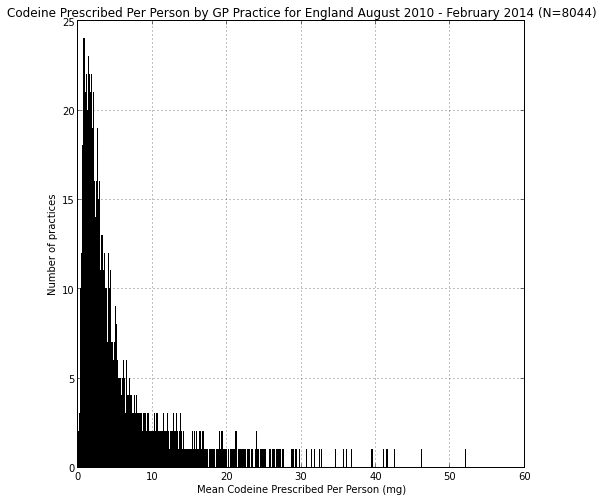

In [103]:
plt.title('Codeine Prescribed Per Person by GP Practice for England August 2010 - February 2014 (N=8044)')
plt.ylabel('Number of practices')
plt.xlabel('Mean Codeine Prescribed Per Person (mg)')

PracticeMeanCodeinePerPerson.hist(bins=8044, figsize=(8,8))

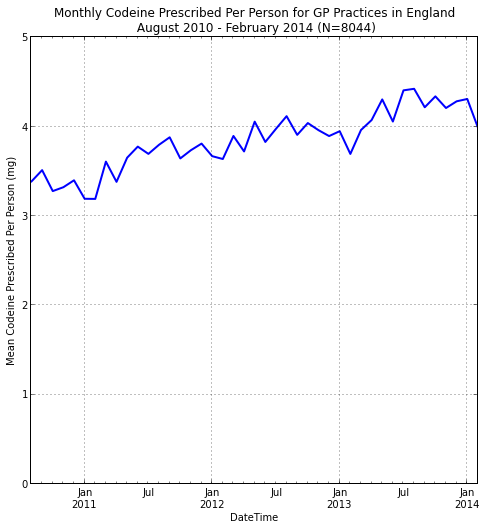

In [104]:
plt.title('Monthly Codeine Prescribed Per Person for GP Practices in England \n August 2010 - February 2014 (N=8044)')
plt.ylabel('Mean Codeine Prescribed Per Person (mg)')

plt.ylim((0,5))
CodeineCCG.groupby('DateTime').QUANTITY_IN_MG_PER_PERSON.mean().plot(linewidth=2.0, figsize=(8,8))


{'boxes': [<matplotlib.lines.Line2D at 0x98f78f10>],
 'caps': [<matplotlib.lines.Line2D at 0x98f78550>,
 'fliers': [<matplotlib.lines.Line2D at 0x98f74950>,
 'medians': [<matplotlib.lines.Line2D at 0x98f74450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x98f7cad0>,
  <matplotlib.lines.Line2D at 0x98f78050>]}

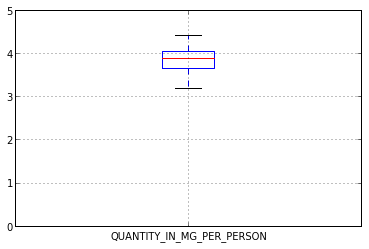

In [105]:
CodeineCCGts = CodeineCCG.groupby('DateTime').QUANTITY_IN_MG_PER_PERSON.mean()
CodeineCCGts = DataFrame(CodeineCCGts).reset_index()

plt.ylim((0,5))
CodeineCCGts.boxplot()

In [106]:
# get some ccg information datas involved

pathtoccgdata = '/home/sam/Documents/OpenDataAbstract/'
os.chdir(pathtoccgdata)
ccg_pop = pd.read_csv('ccgcode_pop.csv')
ccg_names = pd.read_csv('CCG_name.csv')

In [107]:
ccg_names = ccg_names.drop_duplicates() # deduplicate for merging

In [108]:
ccg_pop = pd.merge(ccg_pop, ccg_names, on='CCGCODE') # merge the info datas
ccg_pop.head()


,CCG13CD,Population,CCGCODE,CCG_Name
0,E38000001,156100,02N,"NHS AIREDALE, WHARFDALE AND CRAVEN CCG"
1,E38000002,124180,09C,NHS ASHFORD CCG
2,E38000003,199082,10Y,NHS AYLESBURY VALE CCG
3,E38000004,203928,07L,NHS BARKING AND DAGENHAM CCG
4,E38000005,382127,07M,NHS BARNET CCG


In [109]:
grouped = CodeineCCG.groupby(['CCG13CD', 'DateTime']).QUANTITY_IN_MG.sum() # group by ccg and date time, sum the mg of codeine
grouped = DataFrame(grouped).reset_index()
grouped2 = pd.merge(grouped, ccg_pop, on='CCG13CD')

    

In [110]:
grouped2['QUANTITY_IN_MG_PER_PERSON'] = grouped2['QUANTITY_IN_MG'] / grouped2['Population'] # make it per person using ccg pop data
grouped2.index = grouped2.DateTime

grouped3 = grouped2['2014-02-01'] # lets just have a look at most recent data
# grouped3.QUANTITY_IN_MG_PER_PERSON.sort()

grouped3.sort(columns='QUANTITY_IN_MG_PER_PERSON').describe() # sort and do summary stats


,QUANTITY_IN_MG,Population,QUANTITY_IN_MG_PER_PERSON
count,210.000000,210.000000,210.000000
mean,3183361.690476,264519.238095,11.991664
std,3897609.739547,140256.254353,12.136524
min,74880.000000,69813.000000,0.362594
25%,833591.250000,171376.750000,3.859949
50%,2092270.500000,226502.000000,8.601235
75%,3826403.750000,301981.500000,15.252556
max,31063706.000000,897534.000000,73.727619


In [111]:
grouped3.sort(columns='QUANTITY_IN_MG_PER_PERSON').min() # which ccg has lowest per person mg of codeine prescribe?

CCG13CD                                                   E38000001
DateTime                                        2014-02-01 00:00:00
QUANTITY_IN_MG                                                74880
Population                                                    69813
CCGCODE                                                         00C
CCG_Name                     NHS AIREDALE, WHARFDALE AND CRAVEN CCG
QUANTITY_IN_MG_PER_PERSON                                 0.3625943
dtype: object

In [112]:
grouped3.sort(columns='QUANTITY_IN_MG_PER_PERSON').max() # which ccg has highest per person mg of codeine prescribe?

CCG13CD                                E38000211
DateTime                     2014-02-01 00:00:00
QUANTITY_IN_MG                      3.106371e+07
Population                                897534
CCGCODE                                      99Q
CCG_Name                     NHS WYRE FOREST CCG
QUANTITY_IN_MG_PER_PERSON               73.72762
dtype: object

In [113]:
grouped3.sort(columns='QUANTITY_IN_MG_PER_PERSON').median()

QUANTITY_IN_MG               2092270.500000
Population                    226502.000000
QUANTITY_IN_MG_PER_PERSON          8.601235
dtype: float64

In [114]:
grouped3['CCG_Name'].count() #210 CCGs

210

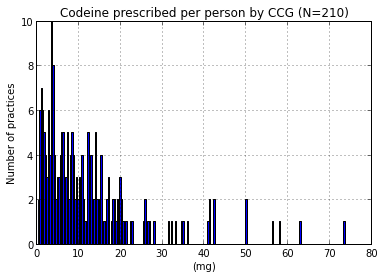

In [115]:
plt.title('Codeine prescribed per person by CCG (N=210)')
plt.ylabel('Number of practices')
plt.xlabel('(mg)')

grouped3['QUANTITY_IN_MG_PER_PERSON'].hist(bins=210)

{'boxes': [<matplotlib.lines.Line2D at 0xb3770290>],
 'caps': [<matplotlib.lines.Line2D at 0xb376e890>,
 'fliers': [<matplotlib.lines.Line2D at 0xb3770c90>,
 'medians': [<matplotlib.lines.Line2D at 0xb3770790>],
 'whiskers': [<matplotlib.lines.Line2D at 0xb35b8e90>,
  <matplotlib.lines.Line2D at 0xb376e390>]}

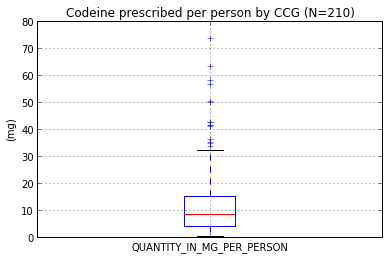

In [116]:
plt.title('Codeine prescribed per person by CCG (N=210)')
plt.ylabel('(mg)')


grouped3.boxplot(column='QUANTITY_IN_MG_PER_PERSON')

In [117]:
ccg_geo = 'ccgs.json'

map = folium.Map(location=[54.2, -2.45], zoom_start=5)
map.geo_json(geo_path=ccg_geo, data_out='Feb2014CodeineByCCG.json', data=grouped3,
      columns=['CCG13CD', 'QUANTITY_IN_MG_PER_PERSON'],
      key_on='feature.properties.CCG13CD',
      fill_color='PuBu', fill_opacity=0.7, line_opacity=0.3,
      legend_name='Codeine prescribed per person by CCG for Feb 2014 (mg)')
map.create_map(path='Feb2014CodeineByCCG.html')

In [118]:
# from IPython.display import IFrame
# IFrame('http://127.0.0.1:8000/Feb2014CodeineByCCG.html', width=700, height=350)
# blocks.org is fiddly with a big ccg.json..

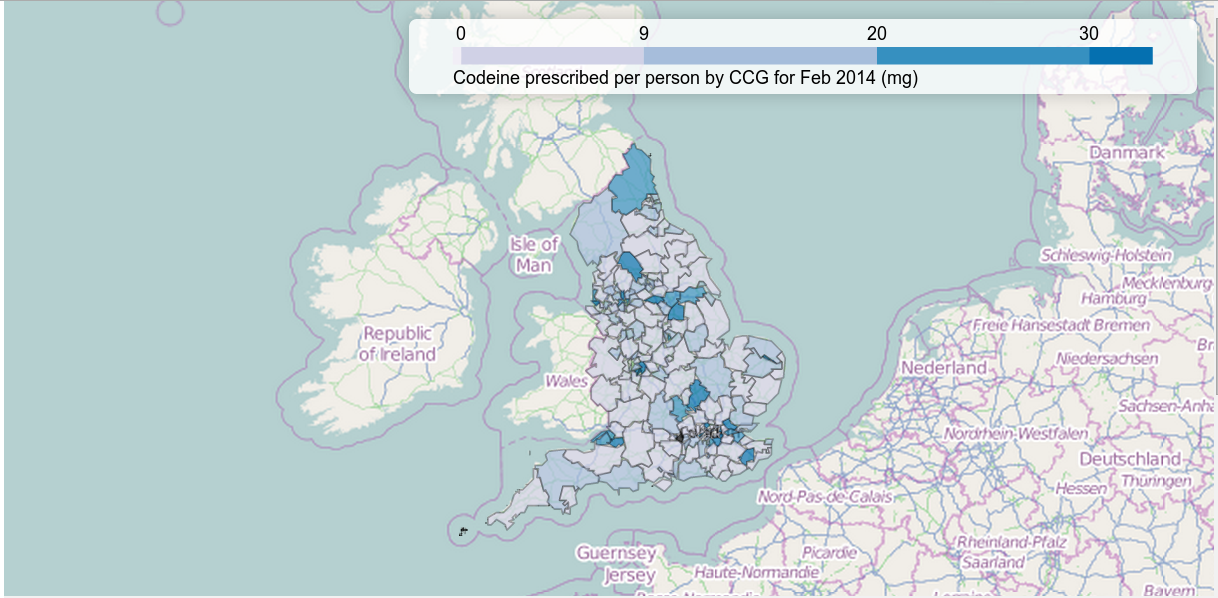

In [119]:
from IPython.display import Image
Embed = Image('opiateanalysis.png')
Embed


In [120]:
for opiate in Opiates:
  print opiate

Codeine
Dihydrocodeine
Tramadol
Tapentadol
Buprenorphine
Fentanyl
Methadone
Morph
Oxycodone


In [121]:
for opiate in Opiates:
    df = pd.DataFrame(eval(opiate).BNF_NAME.unique())
    df['mg of drug per unit of preparation'] = 'tbc'
    df.to_csv('%s_for_Luke_to_complete.csv' % opiate)

In [122]:
import xlrd 
import csv

def csv_from_excel(excel_file):
    
    pathtoxls = "/media/mydisk/prescribing_data/xls"
    pathtocsv = "/media/mydisk/prescribing_data/xls/csv"
    os.chdir(pathtoxls)

    workbook = xlrd.open_workbook(excel_file)
    all_worksheets = workbook.sheet_names()
    for worksheet_name in all_worksheets:
        worksheet = workbook.sheet_by_name(worksheet_name)
        your_csv_file = open(''.join([worksheet_name,'.csv']), 'wb')
        wr = csv.writer(your_csv_file, quoting=csv.QUOTE_ALL)

        for rownum in xrange(worksheet.nrows):
            wr.writerow([unicode(entry).encode("utf-8") for entry in worksheet.row_values(rownum)])
        your_csv_file.close()
        
   

In [151]:
csv_from_excel('/media/mydisk/prescribing_data/xls/Opiates.xls')


In [125]:
cd /media/mydisk/prescribing_data/xls/csv

/media/mydisk/prescribing_data/xls/csv


In [126]:
#Buprenorphine
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Buprenorphine.csv') #lookup prepared by colleague
Buprenorphine['BNF_NAME'] = Buprenorphine['BNF_NAME'].map(str.strip) #get rid of white space
buprenorphine_preps = Buprenorphine['BNF_NAME'].unique().tolist() #get a list of preparation names
buprenorphine_doses = df['mg of drug per unit of preparation'].str.replace('mg', '').astype(float).tolist() #remove the mg my collaborator added
buprenorphine_dose_lookup = dict(zip(buprenorphine_preps, buprenorphine_doses)) #make dict of prep names and codeine doses
Buprenorphine['QUANTITY_IN_MG'] = Buprenorphine['BNF_NAME'].map(lambda x: buprenorphine_dose_lookup[x]) * Buprenorphine['QUANTITY']

In [127]:
#Dihydrocodeine
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Dihydrocodeine.csv') #lookup prepared by colleague
Dihydrocodeine['BNF_NAME'] = Dihydrocodeine['BNF_NAME'].map(str.strip) #get rid of white space
dihydrocodeine_preps = Dihydrocodeine['BNF_NAME'].unique().tolist() #get a list of preparation names
dihydrocodeine_doses = df['mg of drug per unit of preparation'].str.replace('mg', '').astype(float).tolist() #remove the mg my collaborator added
dihydrocodeine_dose_lookup = dict(zip(dihydrocodeine_preps, dihydrocodeine_doses)) #make dict of prep names and codeine doses
Dihydrocodeine['QUANTITY_IN_MG'] = Dihydrocodeine['BNF_NAME'].map(lambda x: dihydrocodeine_dose_lookup[x]) * Dihydrocodeine['QUANTITY']

In [128]:
#Tramadol
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Tramadol.csv') #lookup prepared by colleague
Tramadol['BNF_NAME'] = Tramadol['BNF_NAME'].map(str.strip) #get rid of white space
tramadol_preps = Tramadol['BNF_NAME'].unique().tolist() #get a list of preparation names
tramadol_doses = df['mg of drug per unit of preparation'].tolist() #remove the mg my collaborator added
tramadol_dose_lookup = dict(zip(tramadol_preps, tramadol_doses)) #make dict of prep names and codeine doses
Tramadol['QUANTITY_IN_MG'] = Tramadol['BNF_NAME'].map(lambda x: tramadol_dose_lookup[x]) * Tramadol['QUANTITY']

In [129]:
#Tapentadol
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Tapentadol.csv') #lookup prepared by colleague
Tapentadol['BNF_NAME'] = Tapentadol['BNF_NAME'].map(str.strip) #get rid of white space
tapentadol_preps = Tapentadol['BNF_NAME'].unique().tolist() #get a list of preparation names
tapentadol_doses = df['mg of drug per unit of preparation'].tolist() #remove the mg my collaborator added
tapentadol_dose_lookup = dict(zip(tapentadol_preps, tapentadol_doses)) #make dict of prep names and codeine doses
Tapentadol['QUANTITY_IN_MG'] = Tapentadol['BNF_NAME'].map(lambda x: tapentadol_dose_lookup[x]) * Tapentadol['QUANTITY']

In [130]:
#Fentanyl
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Fentanyl.csv') #lookup prepared by colleague
Fentanyl['BNF_NAME'] = Fentanyl['BNF_NAME'].map(str.strip) #get rid of white space
fentanyl_preps = Fentanyl['BNF_NAME'].unique().tolist() #get a list of preparation names
fentanyl_doses = df['mg of drug per unit of preparation'].tolist() #remove the mg my collaborator added
fentanyl_dose_lookup = dict(zip(fentanyl_preps, fentanyl_doses)) #make dict of prep names and codeine doses
Fentanyl['QUANTITY_IN_MG'] = Fentanyl['BNF_NAME'].map(lambda x: fentanyl_dose_lookup[x]) * Fentanyl['QUANTITY']

In [131]:
#Methadone
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Methadone.csv') #lookup prepared by colleague
Methadone['BNF_NAME'] = Methadone['BNF_NAME'].map(str.strip) #get rid of white space
methadone_preps = Methadone['BNF_NAME'].unique().tolist() #get a list of preparation names
methadone_doses = df['mg of drug per unit of preparation'].str.replace('tbc', '0')#remove the mg my collaborator added
methadone_doses = methadone_doses.astype(float).tolist()
methadone_dose_lookup = dict(zip(methadone_preps, methadone_doses)) #make dict of prep names and codeine doses
Methadone['QUANTITY_IN_MG'] = Methadone['BNF_NAME'].map(lambda x: methadone_dose_lookup[x]) * Methadone['QUANTITY']

In [132]:
#Morphine
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Morphine.csv') #lookup prepared by colleague
Morph['BNF_NAME'] = Morph['BNF_NAME'].map(str.strip) #get rid of white space
morphine_preps = Morph['BNF_NAME'].unique().tolist() #get a list of preparation names
morphine_doses = df['mg of drug per unit of preparation'].str.replace('tbc', '0')
morphine_doses = morphine_doses.astype(float).tolist() #remove the mg my collaborator added
morphine_dose_lookup = dict(zip(morphine_preps, morphine_doses)) #make dict of prep names and codeine doses
Morph['QUANTITY_IN_MG'] = Morph['BNF_NAME'].map(lambda x: morphine_dose_lookup[x]) * Morph['QUANTITY']

In [133]:
#Oxycodone
#work out quantity in mg from prep information and quantity
df = pd.read_csv('Oxycodone.csv') #lookup prepared by colleague
Oxycodone['BNF_NAME'] = Oxycodone['BNF_NAME'].map(str.strip) #get rid of white space
oxycodone_preps = Oxycodone['BNF_NAME'].unique().tolist() #get a list of preparation names
oxycodone_doses = df['mg of drug per unit of preparation'].tolist()
oxycodone_dose_lookup = dict(zip(oxycodone_preps, oxycodone_doses)) #make dict of prep names and codeine doses
Oxycodone['QUANTITY_IN_MG'] = Oxycodone['BNF_NAME'].map(lambda x: oxycodone_dose_lookup[x]) * Oxycodone['QUANTITY']

In [134]:
Opiates

['Codeine',
 'Dihydrocodeine',
 'Tramadol',
 'Tapentadol',
 'Buprenorphine',
 'Fentanyl',
 'Methadone',
 'Morph',
 'Oxycodone']

In [140]:
#do what we should have done ages ago and concat the dataframes
df_list = [Codeine, Dihydrocodeine, Tramadol, Tapentadol, Buprenorphine, Fentanyl, Methadone, Morph, Oxycodone]
AllOpiates = pd.concat(df_list) 

#add gp to ccg datas
AllOpiatesCCG = pd.merge(AllOpiates, gp2ccg, on='PRACTICE')

#add per person quantity using gp pops
AllOpiatesCCG['QUANTITY_IN_MG_PER_PERSON'] = AllOpiatesCCG['QUANTITY_IN_MG'] / AllOpiatesCCG['Population']

#save the output
os.chdir(pathtopickles)
AllOpiates.to_pickle('AllOpiates.pkl')
AllOpiatesCCG.to_pickle('AllOpiatesCCG.pkl')


In [2]:
#load pickles
pathtopickles = '/media/mydisk/prescribing_data/pickles/'
os.chdir(pathtopickles)

AllOpiates = pd.read_pickle('AllOpiates.pkl')
AllOpiatesCCG = pd.read_pickle('AllOpiatesCCG.pkl')

In [7]:
Allgrpd = AllOpiatesCCG.groupby(['CCG13CD', 'DateTime']).QUANTITY_IN_MG.sum() #group by ccg and date time, sum the mg of codeine
Allgrpd = DataFrame(Allgrpd).reset_index()
Allgrpd2 = pd.merge(Allgrpd, ccg_pop, on='CCG13CD')
Allgrpd2['QUANTITY_IN_MG_PER_PERSON'] = Allgrpd2['QUANTITY_IN_MG'] / Allgrpd2['Population'] 


In [35]:
Allgrpd2.QUANTITY_IN_MG_PER_PERSON.describe()

count    9016.000000
mean       82.633108
std        55.761763
min         0.424274
25%        42.247327
50%        72.993361
75%       108.904324
max       330.677633
dtype: float64

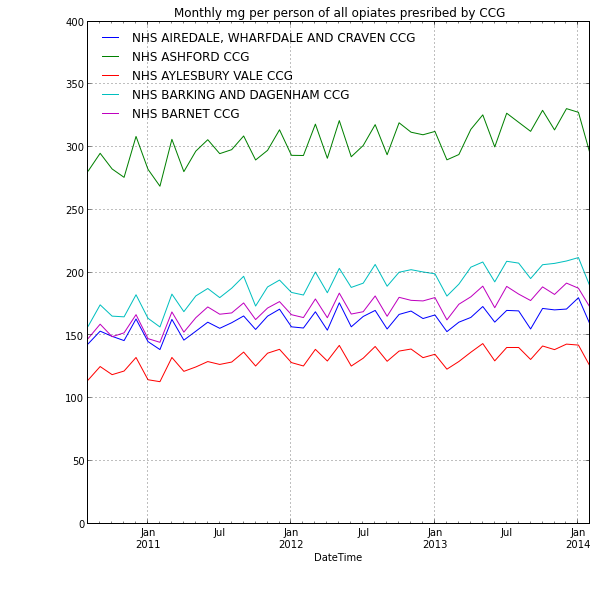

In [152]:
Allgrpd2.index = Allgrpd2.DateTime
plt.title('Monthly mg per person of all opiates presribed by CCG')
plt.ylim((0,400))


for ccg in Allgrpd2.CCG_Name.unique()[:5]:
    Allgrpd2[Allgrpd2['CCG_Name'] == ccg].QUANTITY_IN_MG_PER_PERSON.plot(label=ccg, figsize=(9,9))
    
legend(loc='upper left', frameon=False )


In [52]:
Allgrpd3 = Allgrpd2['2014-02-01'] #cut of most recent data

In [56]:
Allgrpd3.QUANTITY_IN_MG_PER_PERSON.describe()

count    210.000000
mean      81.676466
std       54.669903
min        3.649770
25%       42.182916
50%       71.991737
75%      106.121782
max      293.819912
dtype: float64

In [66]:
Allgrpd3.QUANTITY_IN_MG_PER_PERSON.median()

71.99173676439486

In [59]:
Allgrpd3.head()

,CCG13CD,DateTime,QUANTITY_IN_MG,Population,CCGCODE,CCG_Name,QUANTITY_IN_MG_PER_PERSON
DateTime,,,,,,,
2014-02-01,E38000001,2014-02-01 00:00:00,24695691.059,156100,02N,"NHS AIREDALE, WHARFDALE AND CRAVEN CCG",158.204299
2014-02-01,E38000002,2014-02-01 00:00:00,36486556.674,124180,09C,NHS ASHFORD CCG,293.819912
2014-02-01,E38000003,2014-02-01 00:00:00,24879196.311,199082,10Y,NHS AYLESBURY VALE CCG,124.969592
2014-02-01,E38000004,2014-02-01 00:00:00,38394585.829,203928,07L,NHS BARKING AND DAGENHAM CCG,188.275204
2014-02-01,E38000005,2014-02-01 00:00:00,65696305.506,382127,07M,NHS BARNET CCG,171.922700


{'boxes': [<matplotlib.lines.Line2D at 0x7a599f50>],
 'caps': [<matplotlib.lines.Line2D at 0x7a599590>,
 'fliers': [<matplotlib.lines.Line2D at 0x7afae990>,
 'medians': [<matplotlib.lines.Line2D at 0x7afae490>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7afadb50>,
  <matplotlib.lines.Line2D at 0x7a599090>]}

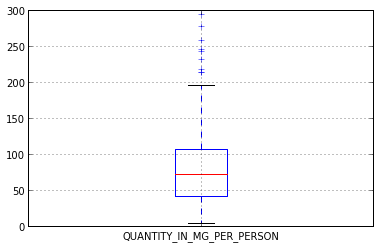

In [65]:
Allgrpd3.boxplot(column='QUANTITY_IN_MG_PER_PERSON')

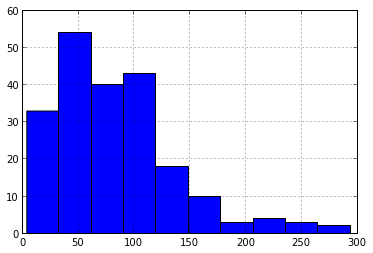

In [62]:
Allgrpd3.QUANTITY_IN_MG_PER_PERSON.hist()

In [53]:
import folium
ccg_geo = 'ccgs.json'

map = folium.Map(location=[54.2, -2.45], zoom_start=5)
map.geo_json(geo_path=ccg_geo, data_out='OpiateByCCG.json', data=Allgrpd3,
      columns=['CCG13CD', 'QUANTITY_IN_MG_PER_PERSON'],
      key_on='feature.properties.CCG13CD',
      fill_color='PuBu', fill_opacity=0.7, line_opacity=0.3,
      legend_name='Opiates prescribed per person by CCG for Feb 2014 (mg)')
map.create_map(path='Feb2014OpiatesByCCG.html')

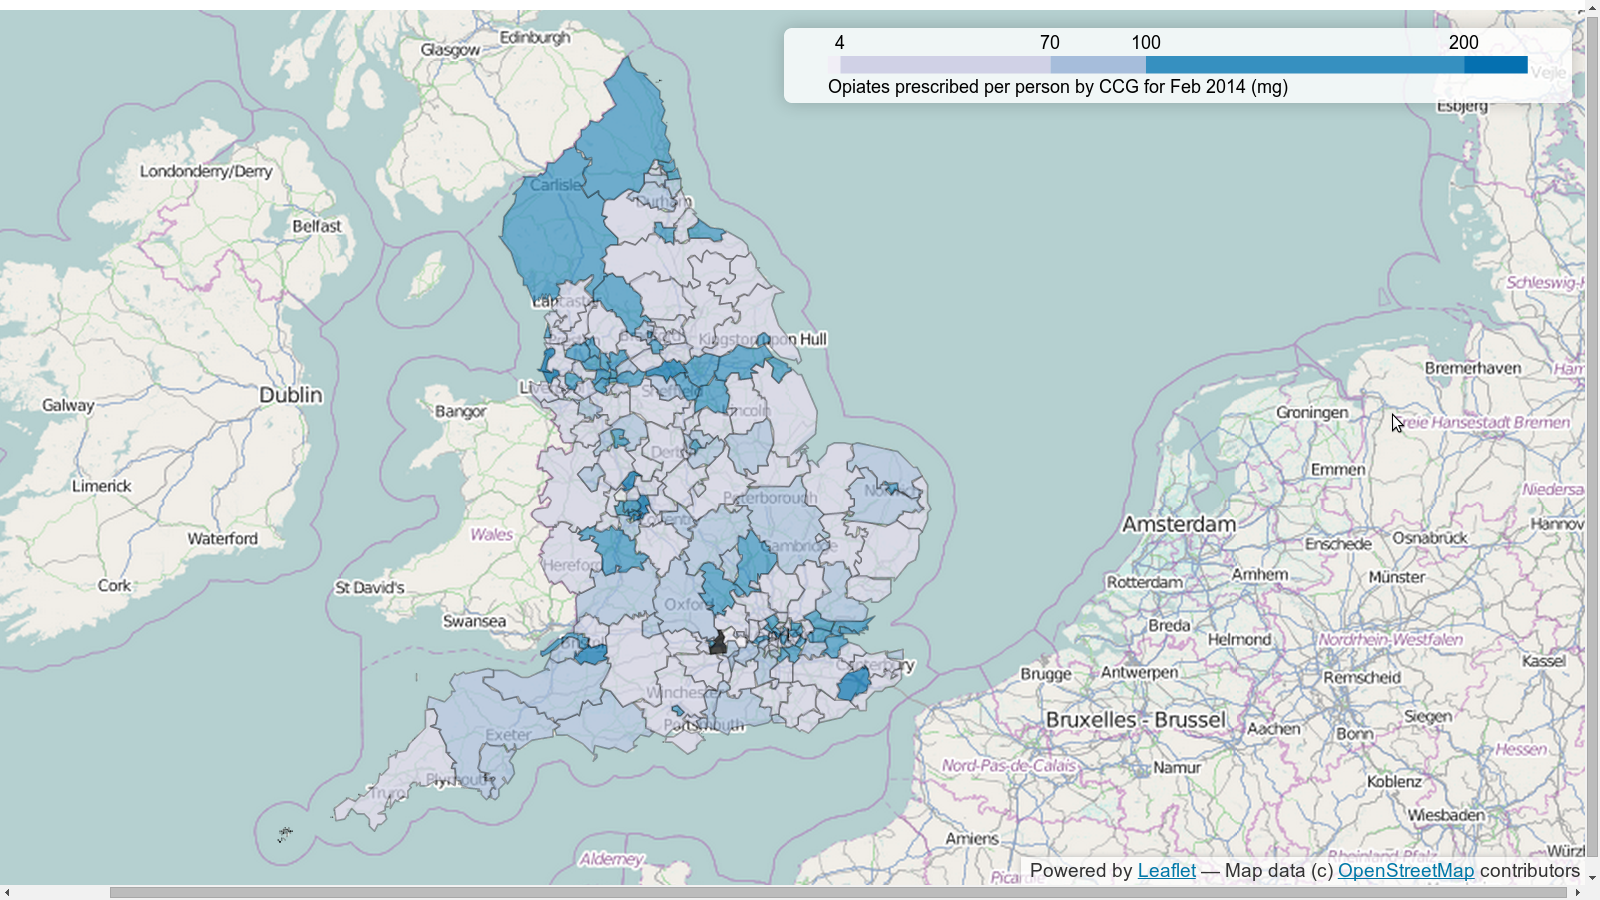

In [55]:
from IPython.display import Image
Embed = Image('opiateanalysis2.png')
Embed


In [123]:
AllOpiatesCCG.groupby('PRACTICE').QUANTITY_IN_MG_PER_PERSON.max().max()

509.2744774477448

In [69]:
AllOpiatesCCG[AllOpiatesCCG['QUANTITY_IN_MG_PER_PERSON'] > 300][:5] #who's that?

,SHA,PCT,PRACTICE,BNF_CODE,BNF_NAME,ITEMS,NIC,ACT_COST,QUANTITY,DateTime,Index,QUANTITY_IN_MG,Population,Practice Name,Unnamed: 0,CCGCODE,CCG13CD,QUANTITY_IN_MG_PER_PERSON
341080,Q30,5ND,A83068,040702040AAAAAA,Tramadol HCl_Cap 50mg,95,665.09,615.10,12346,2010-09-01 00:00:00,,617300,2047,JUPITER HOUSE SURGERY,215,02P,E38000006,301.563263
341092,Q30,5ND,A83068,040702040AAAAAA,Tramadol HCl_Cap 50mg,97,472.24,438.03,12346,2010-12-01 00:00:00,,617300,2047,JUPITER HOUSE SURGERY,215,02P,E38000006,301.563263
341106,Q30,5ND,A83068,040702040AAAAAA,Tramadol HCl_Cap 50mg,109,537.48,498.86,12734,2011-03-01 00:00:00,,636700,2047,JUPITER HOUSE SURGERY,215,02P,E38000006,311.040547
341116,Q30,5ND,A83068,040702040AAAAAA,Tramadol HCl_Cap 50mg,98,439.44,408.07,12878,2011-08-01 00:00:00,,643900,2047,JUPITER HOUSE SURGERY,215,02P,E38000006,314.557890
341120,Q30,5ND,A83068,040702040AAAAAA,Tramadol HCl_Cap 50mg,96,418.14,388.40,12392,2011-09-01 00:00:00,,619600,2047,JUPITER HOUSE SURGERY,215,02P,E38000006,302.686859


In [133]:
AllOpiatesCCG.PRACTICE.nunique()

7946

In [79]:
Allgrpd2.groupby(['DateTime', 'CCG_Name'])['QUANTITY_IN_MG_PER_PERSON'].sum().to_csv('ccgopiatetotals.csv')

In [153]:
Allgrpd2.groupby(['DateTime', 'CCG_Name'])['QUANTITY_IN_MG_PER_PERSON'].sum()

DateTime    CCG_Name                              
2010-08-01  NHS AIREDALE, WHARFDALE AND CRAVEN CCG    143.394051
            NHS ASHFORD CCG                           281.005862
            NHS AYLESBURY VALE CCG                    114.574195
            NHS BARKING AND DAGENHAM CCG              157.400817
            NHS BARNET CCG                            147.652646
            NHS BARNSLEY CCG                          213.565066
            NHS BASILDON AND BRENTWOOD CCG            155.215428
            NHS BASSETLAW CCG                          94.238358
            NHS BATH AND NORTH EAST SOMERSET CCG      196.312690
            NHS BEDFORDSHIRE CCG                      147.830873
            NHS BEXLEY CCG                            179.229206
            NHS BIRMINGHAM CROSSCITY CCG              197.632933
            NHS BIRMINGHAM SOUTH AND CENTRAL CCG      198.647377
            NHS BLACKBURN WITH DARWEN CCG             101.827913
            NHS BLACKPOOL CCG          

In [143]:
for i, item in enumerate(df_list):
    df_list[i] = pd.merge(df_list[i], gp2ccg, on='PRACTICE')
    df_list[i] = df_list[i].groupby(['CCG13CD', 'DateTime']).QUANTITY_IN_MG.sum() #group by ccg and date time, sum the mg of codeine
    df_list[i] = DataFrame(df_list[i]).reset_index()
    df_list[i] = pd.merge(df_list[i], ccg_pop, on='CCG13CD')
    df_list[i]['QUANTITY_IN_MG_PER_PERSON'] = df_list[i]['QUANTITY_IN_MG'] / df_list[i]['Population'] 
    df_list[i].QUANTITY_IN_MG_PER_PERSON.describe()

In [149]:
for i, item in enumerate(df_list):
    df_list[i].groupby(['DateTime', 'CCG_Name'])['QUANTITY_IN_MG_PER_PERSON'].sum().to_csv('%stotals.csv' % Opiates[i])

In [12]:
ls GP*

GP_registered_patients_2012.csv


In [13]:
gps = pd.read_csv('GP_registered_patients_2012.csv')


In [15]:
gps.CCG_Code.nunique()

211

In [ ]:
df